In [1]:
import torch
import torch.nn as nn
from utils import data_loader
from utils.viewer import show_batch
import time
from mnist_classifier import test_model
from multiple_attacks import *
import numpy as np

In [2]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [3]:
train_set, test_set = data_loader.get_data()

In [4]:
class VFAE_CONV_NeuralModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)

        )

        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 16, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True)
        )

        self.fc_mu = nn.Linear(50, 50)
        self.fc_log_var = nn.Linear(50, 50)

        # Sampling vector
        self.latent = nn.Sequential(

            nn.Linear(50, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),

            nn.Linear(50, 7 * 7 * 16),
            nn.BatchNorm1d(7 * 7 * 16),
            nn.ReLU(inplace=True)

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()

        )

    def reparameterize(self, mean, log_var):
        if self.training:
            std = log_var.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mean)
        else:
            return mean

    def forward(self, x):
        z, mu, log_var = self.get_latent(x)
        feature_map_latent = z.view(-1, 16, 7, 7)

        decoded = self.decoder(feature_map_latent)
        output = decoded.view(-1, 1, 28, 28)

        return output, mu, log_var
    
    def get_latent(self, x):
        encoded = self.encoder(x)

        encoded = encoded.view(-1, 7 * 7 * 16)

        fc = self.fc(encoded)

        mu = self.fc_mu(fc)
        log_var = self.fc_log_var(fc)

        z = self.reparameterize(mu, log_var)
        latent = self.latent(z)
        
        return latent, mu, log_var
        
        

In [ ]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# vae = VAE_FC_NeuralModel()

def VAELoss(x_hat, x, mu, logvar, a, b):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return a*BCE + b*KLD

In [ ]:
b_size = 256
def MMD_Loss(x, y):
    
    alpha =1
    B=b_size

    x = x.view(x.size(0), x.size(1) * 1)
    y = y.view(y.size(0), y.size(1) * 1)

    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    K = torch.exp(- alpha * (rx.t() + rx - 2*xx))
    L = torch.exp(- alpha * (ry.t() + ry - 2*yy))
    P = torch.exp(- alpha * (rx.t() + ry - 2*zz))

    beta = (1./(B*(B-1)))
    gamma = (2./(B*B)) 

    return beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)

In [ ]:
def train_vae(model, train_data,a, b, adv_examples = False):
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    model.to(device)
    if adv_examples is True: 
    # invariant representation training
        for train in train_data:
            for batch in train:
                batch_images, adv_images, batch_labels = batch

                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)
                adv_images = adv_images.to(device)

                batch_output, mean, log_var = model(batch_images)

                latent_1, _, _ = model.get_latent(batch_images.detach())
                latent_2, _, _ = model.get_latent(adv_images.detach())

                down_stream_loss = VAELoss(batch_output, batch_images.detach(), mean, log_var, a, b)
                representation_loss = MMD_Loss(latent_1, latent_2)

                total_loss = .00001*down_stream_loss + 10000*representation_loss


                optimizer.zero_grad()
                total_loss.backward(retain_graph=True)
                optimizer.step()

                print("The classification loss after processing this batch is: ", down_stream_loss.item())
                print("The representation loss after processing this batch is: ", representation_loss.item())

    else:
        ## normal training
        for batch in train_data:
            batch_images, _ = batch
            batch_images = batch_images.to(device)

            batch_output, mean, log_var = model(batch_images)
            loss = VAELoss(batch_output, batch_images, mean, log_var, a, b)

            optimizer.zero_grad()
            loss.backward()
            print("*&**"*30)
            print("the loss after processing this batch is: ", loss.item())
            optimizer.step()

    return model

In [ ]:
initial_vae = VFAE_CONV_NeuralModel().to(device)
#initial_vae = train_vae(initial_vae, train_loader, a=1, b=1, False)
#torch.save(initial_vae.state_dict(), "models/trained_vae_b=1_variant_rep")
initial_vae.load_state_dict(torch.load("models/trained_vae_b=1_variant_rep"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

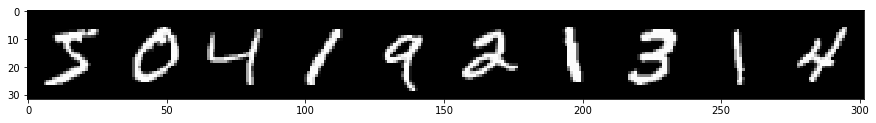

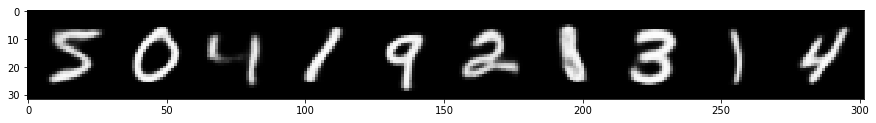

In [ ]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
train_loader_iter = iter(train_loader)
first_images, first_labels = next(train_loader_iter)

show_batch(first_images)

recs, _, _ = initial_vae(first_images.to(device))
show_batch(recs.cpu())

In [ ]:
class VFAEEClassifier(nn.Module):
    def __init__(self, beta, initial_VAE):
        super().__init__()
        
        self.vae = initial_vae
        
        self.classifier_part = self.encoder = nn.Sequential(

            nn.Conv2d(16, 14, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(14),
            nn.ReLU(inplace=True),

            nn.Conv2d(14, 12, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(12, 10, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(10),
            
        )
        
        self.fc = nn.Linear(10 * 1 * 1, 10)
        # no_of_last_channels* kernel_H * kernel_W, output_from_fully_conncected 
    def forward(self, x):
        #with torch.no_grad():
        vaee_features, _, _ = self.vae.get_latent(x)

        vaee_features = vaee_features.reshape(-1, 16, 7, 7)
        convolved = self.classifier_part(vaee_features)

        classification_logits = self.fc(convolved.view(convolved.size(0), -1))
        
        return  classification_logits
    

In [ ]:
def train_classifier(model, train_data):
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_epochs = 1
    model.train()
    
    model.to(device)
    
    for epoch in range(n_epochs):
        if epoch %2 == 0:
            learning_rate /= 2.5
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for batch in train_data:
            batch_images, batch_labels = batch
            
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            batch_output = model(batch_images)
            loss = criterion(batch_output, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            model.vae = initial_classifier.vae
        print("the loss after processing this epoch is: ", loss.item())
            
    return model

In [ ]:
b=1

initial_classifier = VFAEEClassifier(beta=b, initial_VAE=initial_vae).to(device)
model =  VFAEEClassifier(beta=b, initial_VAE=initial_vae).to(device)

batch_size = 256
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
model = train_classifier(model, train_loader)

the loss after processing this epoch is:  0.08298791199922562


In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
testing_accuracy_before_attack = test_model(model, test_loader)
print(testing_accuracy_before_attack)

0.9856


In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)
import time 
time_1 = time.time()

print(attack(model, device, train_loader, fgsm, 0.3)[0])
print("=*" * 20)
time_2 = time.time()
print(time_2 - time_1)

print(attack(model, device, train_loader, pgd, 0.3, 1e4, 40)[0])
print("=*" * 20)

time_1 = time.time()

print(attack(model, device, train_loader, pgd_linf, 0.3, 1e-2, 40)[0])
print("=*" * 20)
time_2 = time.time()
print(time_2 - time_1)

time_1 = time.time()
print(attack(model, device, train_loader, pgd_l2, 1, 0.3, 40)[0])
time_2 = time.time()
print(time_2 - time_1)


FGSM Attack : 
0.13571666666666668
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
6.88317346572876
Projected Gradient Attack : 
0.0844
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
iFGSM Attack : 
0.00013333333333333334
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
104.80234336853027
Deep Fool Attack : 


In [ ]:
def get_training_examples(model): 
    training_examples = []

    examples = get_examples(model, device, train_loader, fgsm, 0.3)
    training_examples.append(examples)

    examples = get_examples(model, device, train_loader, pgd, 0.3, 1e4, 40)
    training_examples.append(examples)

    examples = get_examples(model, device, train_loader, pgd_linf, 0.3, 1e-2, 40)
    training_examples.append(examples)
    training_examples.append(examples)
    training_examples.append(examples)
    training_examples.append(examples)
    
    examples = get_examples(model, device, train_loader, pgd_l2, 1.3, 0.3, 40)

    return training_examples

In [ ]:
def train_classifier_adv(model, train_data):
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_epochs = 10
    model.train()
    
    model.to(device)
    
    for epoch in range(n_epochs):
        if epoch %2 == 0:
            learning_rate /= 2.5
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for train in train_data:
            for batch in train:
                batch_images, adv_images, batch_labels = batch

                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)
                adv_images = adv_images.to(device)

                batch_output = model(batch_images)
                loss = criterion(batch_output, batch_labels)
                
                adv_output = model(adv_images)
                
                loss += criterion(adv_output, batch_labels )
                optimizer.zero_grad()
                loss.backward()

                optimizer.step()
                model.vae = initial_classifier.vae
        print("the loss after processing this epoch is: ", loss.item())
            
    return model

In [ ]:
vafee = VFAE_CONV_NeuralModel().to(device)
initial_classifier = VFAEEClassifier(beta=b, initial_VAE=vafee).to(device)

for i in range(10):
    training_examples = get_training_examples(model)
    vafee = train_vae(vafee, training_examples, 1, 1, adv_examples= True)
   
    model =  VFAEEClassifier(beta=1, initial_VAE=vafee).to(device)

    batch_size = 128
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    model = train_classifier_adv(model, training_examples)

In [ ]:
import time
time_1 = time.time()
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)
print(attack(model, device, test_loader, fgsm, 0.3)[0])
print("=*" * 20)
time_2 = time.time()

print(time_2-time_1)

In [ ]:
print(attack(model, device, test_loader, pgd, 0.3, 1e4, 40)[0])
print("=*" * 20)

In [ ]:
time_1 = time.time()
print(attack(model, device, test_loader, pgd_linf, 0.3, 1e-2, 40)[0])
print("=*" * 20)
time_2 = time.time()

print(time_2-time_1)

In [ ]:
print(attack(model, device, test_loader, pgd_l2,  1, 0.3, 40)[0])

In [ ]:
## modify multiplication factors
## modify printed text "classification loss to reconstruction loss"

In [ ]:
fgsms = []
pgds = []
ifgsms=[]
deepfools=[]
epsilons = [0, .05, .1, .15, .2, .25, .3]
for eps in epsilons :
    fgsms.append(attack(model, device, test_loader, fgsm, eps)[0])

    pgds.append(attack(model, device, test_loader, pgd, eps, 1e4, 40)[0])

    ifgsms.append(attack(model, device, test_loader, pgd_linf, eps, 1e-2, 40)[0])

    deepfools.append(attack(model, device, test_loader, pgd_l2, 1.3, eps, 40)[0])
    

In [ ]:
plt.plot(epsilons, fgsms, label = 'fgsm')
plt.plot(epsilons, pgds, label ="pgd")
plt.plot(epsilons, ifgsms, label = 'ifgsm')
plt.plot(epsilons, deepfools, label = 'deep fool L2')
plt.legend() 

plt.xlabel('$\epsilon$', size = 'xx-large', fontweight = 'demi')
plt.ylabel('Accuracy', size = 'x-large')
plt.ylim([0,1.0])
plt.yticks(np.linspace(0,1,11))
plt.savefig('figures/vafee4_111_classifier.pdf', format='pdf', bbox_inches='tight', quality = 100)
plt.show()